In [1]:
!pip install opendatasets

In [2]:
import opendatasets as od
od.download('https://www.kaggle.com/datasets/kushagratandon12/diabetic-retinopathy-balanced')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: talhanaveed00
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/kushagratandon12/diabetic-retinopathy-balanced


100%|██████████| 1.90G/1.90G [00:46<00:00, 43.7MB/s]


In [3]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from transformers import ViTForImageClassification
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
import shap

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [5]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [6]:
# Loading Dataset
train_dataset = datasets.ImageFolder(root='/content/diabetic-retinopathy-balanced/content/Diabetic_Balanced_Data/train', transform=transform)
val_dataset = datasets.ImageFolder(root='/content/diabetic-retinopathy-balanced/content/Diabetic_Balanced_Data/val', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)

In [7]:
model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224", num_labels=5, ignore_mismatched_sizes=True
)
model.to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([5]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([5, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
scaler = torch.cuda.amp.GradScaler()

<ipython-input-8-39165d37fbef>:3: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


In [9]:
def train(model, train_loader, val_loader, epochs=10):
    for epoch in range(epochs):
        model.train()
        total_loss, correct = 0, 0
        all_preds, all_labels = [], []

        for images, labels in train_loader:
            images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            optimizer.zero_grad()

            with torch.cuda.amp.autocast():
                outputs = model(images).logits
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            total_loss += loss.item()
            preds = outputs.argmax(1)
            correct += (preds == labels).sum().item()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        train_acc = correct / len(train_loader.dataset)
        train_f1 = f1_score(all_labels, all_preds, average='weighted')
        train_precision = precision_score(all_labels, all_preds, average='weighted')
        train_recall = recall_score(all_labels, all_preds, average='weighted')

        print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader)}, Train Accuracy: {train_acc:.4f}")
        print(f"Precision: {train_precision:.4f}, Recall: {train_recall:.4f}, F1-score: {train_f1:.4f}")
        test(model, val_loader)

In [10]:
def test(model, val_loader):
    model.eval()
    correct, total = 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            outputs = model(images).logits
            predictions = outputs.argmax(1)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)
            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = correct / total
    f1 = f1_score(all_labels, all_preds, average='weighted')
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')

    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")
    visualize_gradcam(model, val_loader)

In [11]:
# Grad-CAM Visualization
def visualize_gradcam(model, dataloader):
    images, labels = next(iter(dataloader))
    images, labels = images.to(device), labels.to(device)

    model.eval()
    outputs = model(images).logits
    predictions = outputs.argmax(1)

    fig, axes = plt.subplots(1, 5, figsize=(15, 5))
    for i in range(5):
        img = images[i].cpu().permute(1, 2, 0).numpy()
        axes[i].imshow(img)
        axes[i].set_title(f"Pred: {predictions[i].item()}, Actual: {labels[i].item()}")
        axes[i].axis("off")
    plt.show()

In [12]:
def shap_explain(model, dataloader):
    model.eval()
    batch = next(iter(dataloader))[0][:10].to(device)
    explainer = shap.GradientExplainer(model, batch)
    shap_values = explainer.shap_values(batch)
    shap.image_plot(shap_values, batch.cpu().numpy())

<ipython-input-9-76b6a7b2b59f>:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 1, Loss: 0.9773046762189445, Train Accuracy: 0.5747
Precision: 0.5775, Recall: 0.5747, F1-score: 0.5753
Test Accuracy: 0.6418
Precision: 0.6616, Recall: 0.6418, F1-score: 0.6370


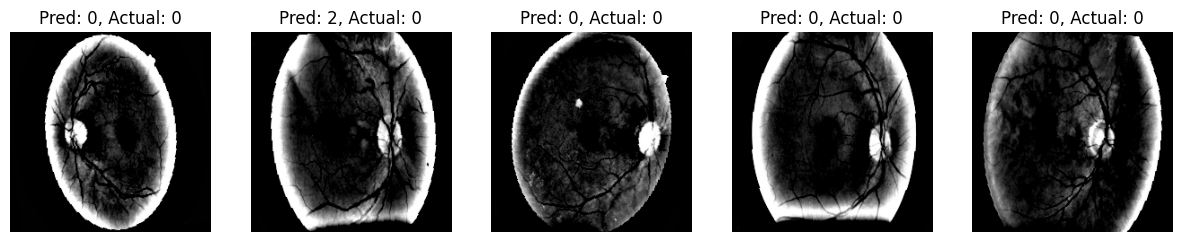

<ipython-input-9-76b6a7b2b59f>:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 2, Loss: 0.7619639190790408, Train Accuracy: 0.6739
Precision: 0.6778, Recall: 0.6739, F1-score: 0.6753
Test Accuracy: 0.6995
Precision: 0.7066, Recall: 0.6995, F1-score: 0.7006


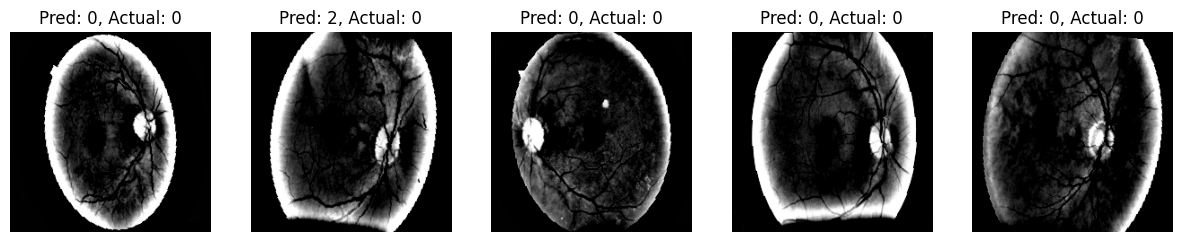

<ipython-input-9-76b6a7b2b59f>:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 3, Loss: 0.6109236730262637, Train Accuracy: 0.7367
Precision: 0.7389, Recall: 0.7367, F1-score: 0.7372
Test Accuracy: 0.7159
Precision: 0.7356, Recall: 0.7159, F1-score: 0.7210


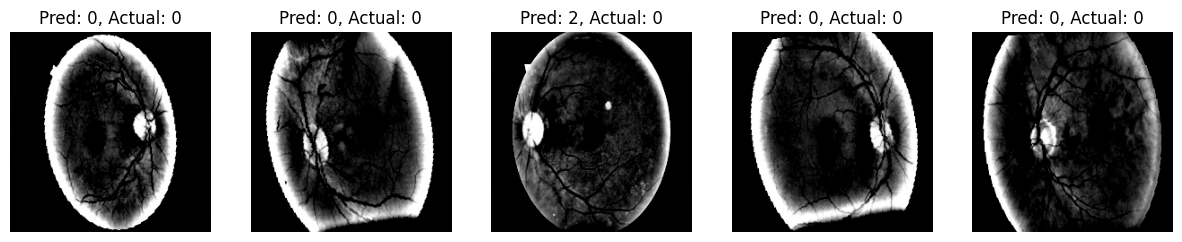

<ipython-input-9-76b6a7b2b59f>:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 4, Loss: 0.5034456832663101, Train Accuracy: 0.7868
Precision: 0.7884, Recall: 0.7868, F1-score: 0.7871
Test Accuracy: 0.7568
Precision: 0.7575, Recall: 0.7568, F1-score: 0.7541


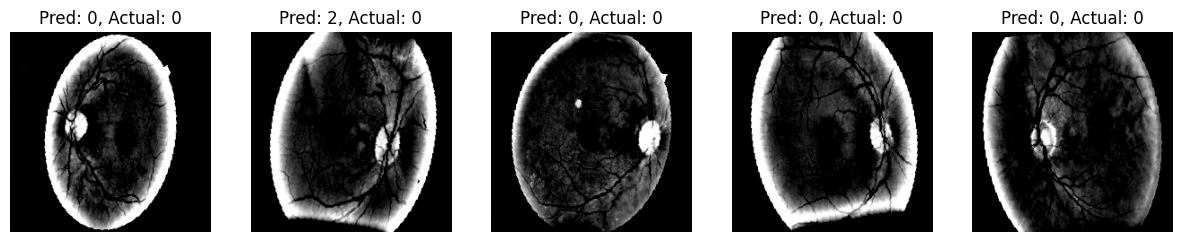

<ipython-input-9-76b6a7b2b59f>:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 5, Loss: 0.42183390572009716, Train Accuracy: 0.8241
Precision: 0.8252, Recall: 0.8241, F1-score: 0.8243
Test Accuracy: 0.7743
Precision: 0.7737, Recall: 0.7743, F1-score: 0.7739


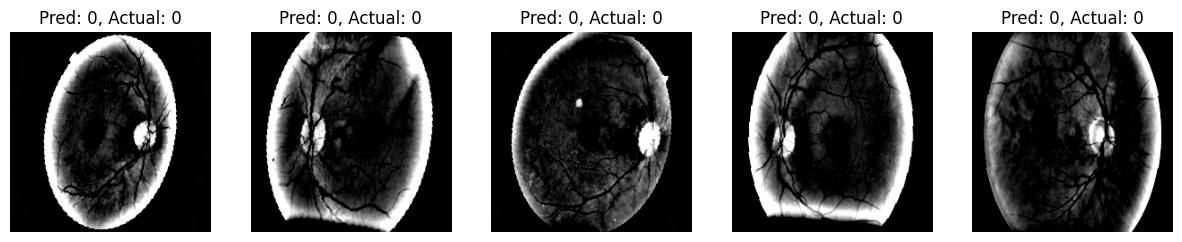

<ipython-input-9-76b6a7b2b59f>:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 6, Loss: 0.3378700315404464, Train Accuracy: 0.8630
Precision: 0.8638, Recall: 0.8630, F1-score: 0.8632
Test Accuracy: 0.7907
Precision: 0.7923, Recall: 0.7907, F1-score: 0.7910


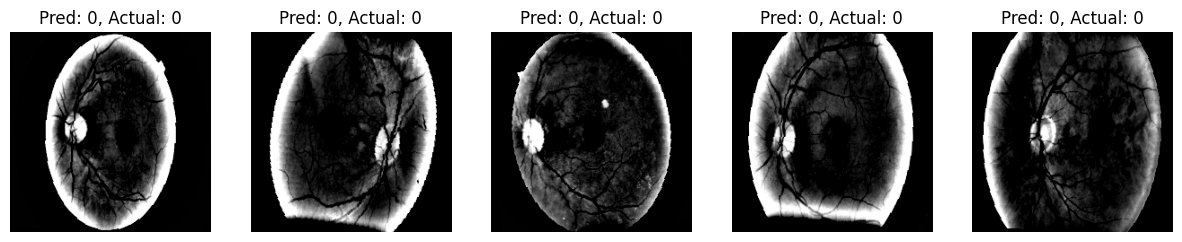

<ipython-input-9-76b6a7b2b59f>:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 7, Loss: 0.266533934387981, Train Accuracy: 0.8933
Precision: 0.8937, Recall: 0.8933, F1-score: 0.8934
Test Accuracy: 0.8034
Precision: 0.8026, Recall: 0.8034, F1-score: 0.8012


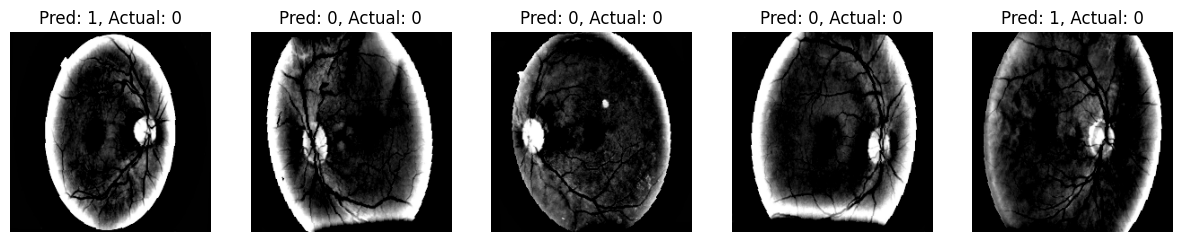

<ipython-input-9-76b6a7b2b59f>:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 8, Loss: 0.21622107951792285, Train Accuracy: 0.9160
Precision: 0.9164, Recall: 0.9160, F1-score: 0.9161
Test Accuracy: 0.8058
Precision: 0.8092, Recall: 0.8058, F1-score: 0.8040


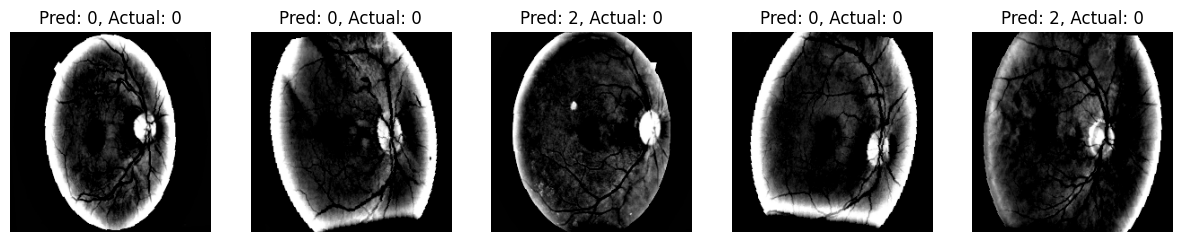

<ipython-input-9-76b6a7b2b59f>:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 9, Loss: 0.1614762962631443, Train Accuracy: 0.9407
Precision: 0.9408, Recall: 0.9407, F1-score: 0.9408
Test Accuracy: 0.8289
Precision: 0.8268, Recall: 0.8289, F1-score: 0.8271


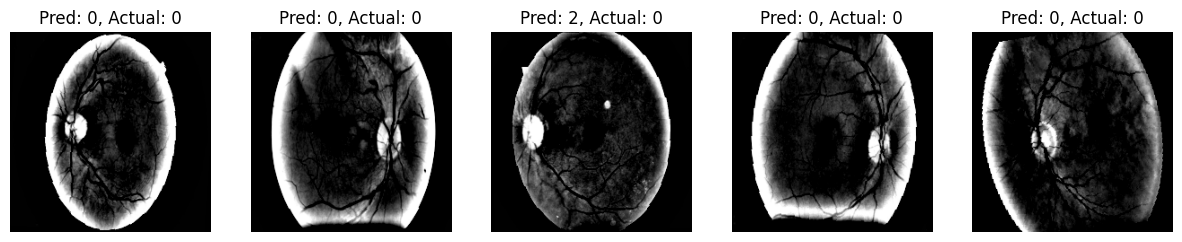

<ipython-input-9-76b6a7b2b59f>:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 10, Loss: 0.12850831769516363, Train Accuracy: 0.9518
Precision: 0.9519, Recall: 0.9518, F1-score: 0.9518
Test Accuracy: 0.8295
Precision: 0.8299, Recall: 0.8295, F1-score: 0.8294


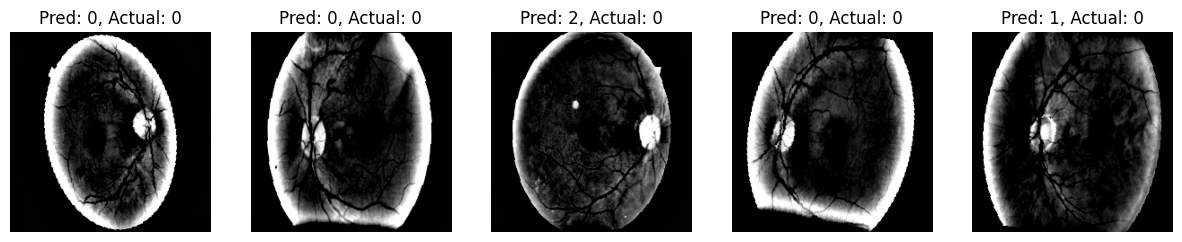

<ipython-input-9-76b6a7b2b59f>:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 11, Loss: 0.10750683648032411, Train Accuracy: 0.9617
Precision: 0.9618, Recall: 0.9617, F1-score: 0.9618
Test Accuracy: 0.8258
Precision: 0.8233, Recall: 0.8258, F1-score: 0.8228


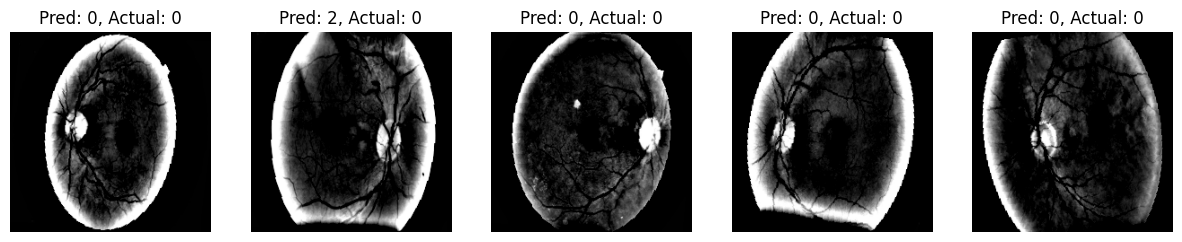

<ipython-input-9-76b6a7b2b59f>:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 12, Loss: 0.09532210819067105, Train Accuracy: 0.9642
Precision: 0.9642, Recall: 0.9642, F1-score: 0.9642
Test Accuracy: 0.8362
Precision: 0.8423, Recall: 0.8362, F1-score: 0.8375


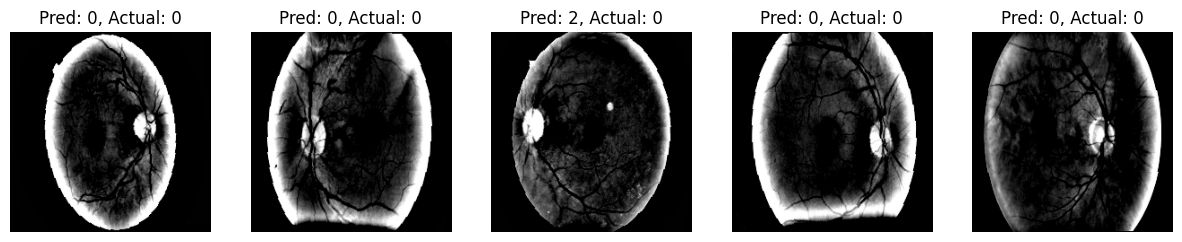

<ipython-input-9-76b6a7b2b59f>:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 13, Loss: 0.08435429936370757, Train Accuracy: 0.9690
Precision: 0.9690, Recall: 0.9690, F1-score: 0.9690
Test Accuracy: 0.8434
Precision: 0.8456, Recall: 0.8434, F1-score: 0.8424


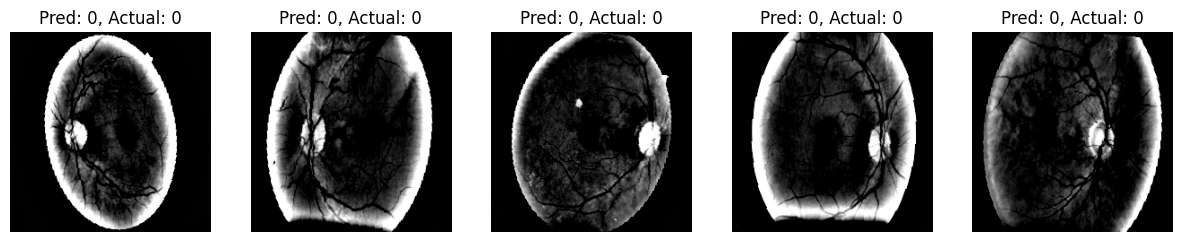

<ipython-input-9-76b6a7b2b59f>:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 14, Loss: 0.07239005697192624, Train Accuracy: 0.9740
Precision: 0.9740, Recall: 0.9740, F1-score: 0.9740
Test Accuracy: 0.8490
Precision: 0.8491, Recall: 0.8490, F1-score: 0.8490


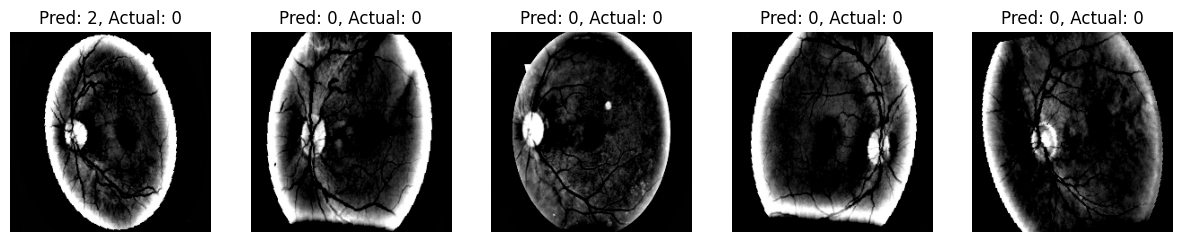

<ipython-input-9-76b6a7b2b59f>:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 15, Loss: 0.06837359102620907, Train Accuracy: 0.9757
Precision: 0.9757, Recall: 0.9757, F1-score: 0.9757
Test Accuracy: 0.8580
Precision: 0.8609, Recall: 0.8580, F1-score: 0.8586


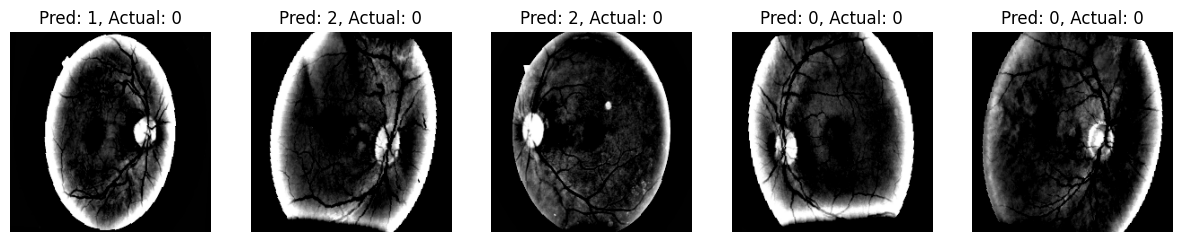

<ipython-input-9-76b6a7b2b59f>:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 16, Loss: 0.057713901504244214, Train Accuracy: 0.9795
Precision: 0.9795, Recall: 0.9795, F1-score: 0.9795
Test Accuracy: 0.8444
Precision: 0.8451, Recall: 0.8444, F1-score: 0.8419


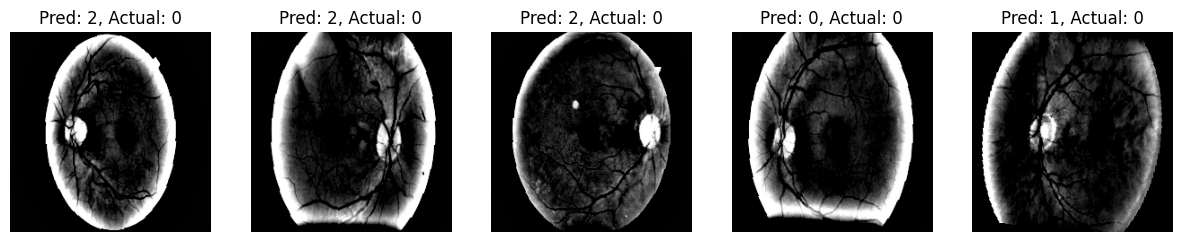

<ipython-input-9-76b6a7b2b59f>:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 17, Loss: 0.05947795622256201, Train Accuracy: 0.9790
Precision: 0.9791, Recall: 0.9790, F1-score: 0.9791
Test Accuracy: 0.8469
Precision: 0.8489, Recall: 0.8469, F1-score: 0.8434


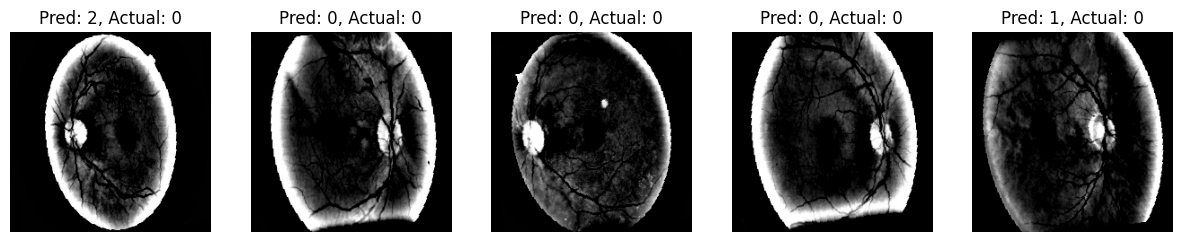

<ipython-input-9-76b6a7b2b59f>:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 18, Loss: 0.047691074013367626, Train Accuracy: 0.9835
Precision: 0.9835, Recall: 0.9835, F1-score: 0.9835
Test Accuracy: 0.8309
Precision: 0.8351, Recall: 0.8309, F1-score: 0.8246


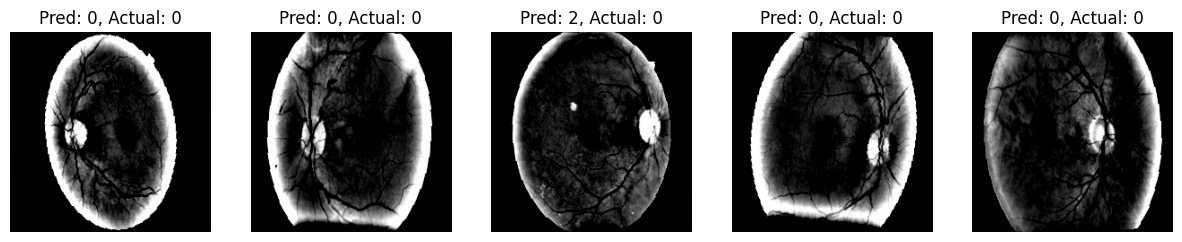

<ipython-input-9-76b6a7b2b59f>:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 19, Loss: 0.05788251060927424, Train Accuracy: 0.9790
Precision: 0.9791, Recall: 0.9790, F1-score: 0.9790
Test Accuracy: 0.8597
Precision: 0.8598, Recall: 0.8597, F1-score: 0.8585


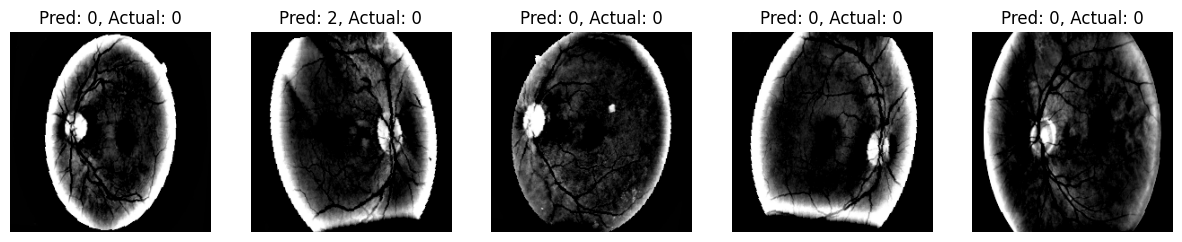

<ipython-input-9-76b6a7b2b59f>:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 20, Loss: 0.04318952621029252, Train Accuracy: 0.9843
Precision: 0.9843, Recall: 0.9843, F1-score: 0.9843
Test Accuracy: 0.8554
Precision: 0.8574, Recall: 0.8554, F1-score: 0.8540


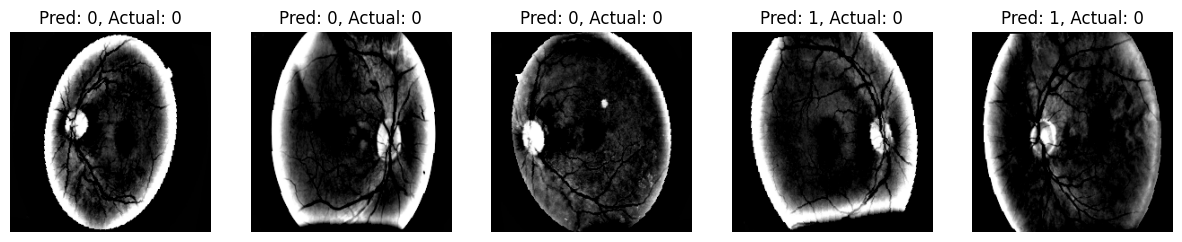

<ipython-input-9-76b6a7b2b59f>:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 21, Loss: 0.04076631211757879, Train Accuracy: 0.9855
Precision: 0.9855, Recall: 0.9855, F1-score: 0.9855
Test Accuracy: 0.8391
Precision: 0.8377, Recall: 0.8391, F1-score: 0.8345


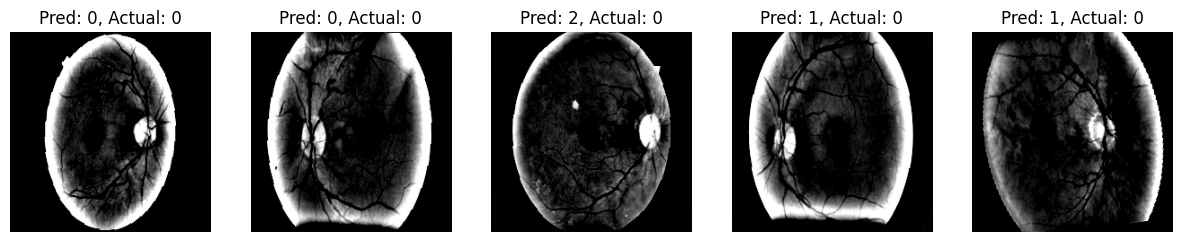

<ipython-input-9-76b6a7b2b59f>:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 22, Loss: 0.044923845661447984, Train Accuracy: 0.9847
Precision: 0.9847, Recall: 0.9847, F1-score: 0.9847
Test Accuracy: 0.8494
Precision: 0.8499, Recall: 0.8494, F1-score: 0.8469


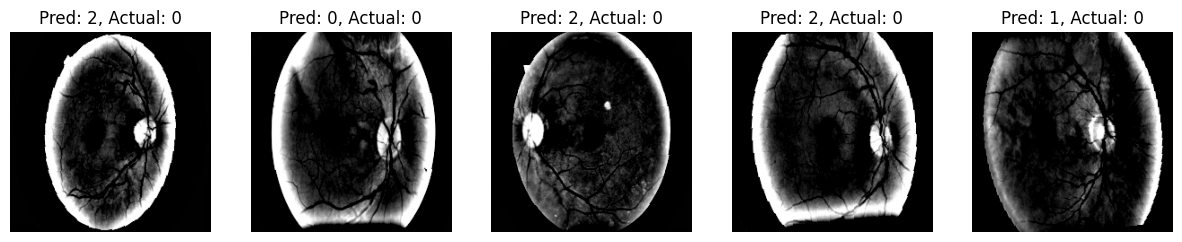

<ipython-input-9-76b6a7b2b59f>:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 23, Loss: 0.04681513486738207, Train Accuracy: 0.9840
Precision: 0.9840, Recall: 0.9840, F1-score: 0.9840
Test Accuracy: 0.8569
Precision: 0.8564, Recall: 0.8569, F1-score: 0.8554


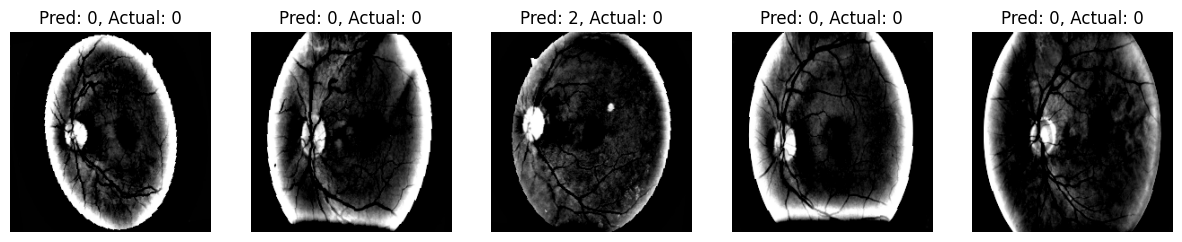

<ipython-input-9-76b6a7b2b59f>:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 24, Loss: 0.032374372217900065, Train Accuracy: 0.9887
Precision: 0.9887, Recall: 0.9887, F1-score: 0.9887
Test Accuracy: 0.8683
Precision: 0.8660, Recall: 0.8683, F1-score: 0.8666


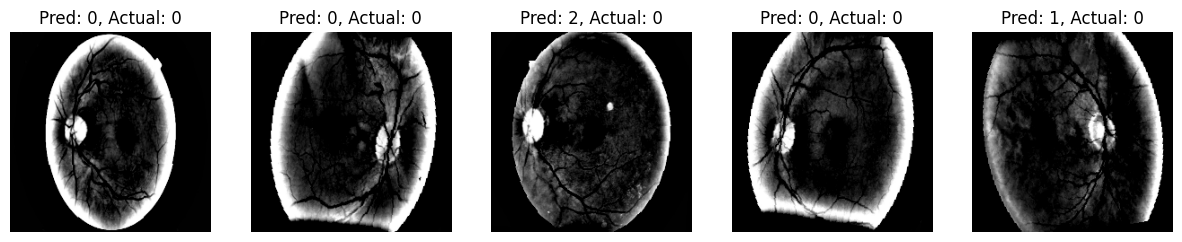

<ipython-input-9-76b6a7b2b59f>:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 25, Loss: 0.0388782537638155, Train Accuracy: 0.9868
Precision: 0.9868, Recall: 0.9868, F1-score: 0.9868
Test Accuracy: 0.8510
Precision: 0.8502, Recall: 0.8510, F1-score: 0.8478


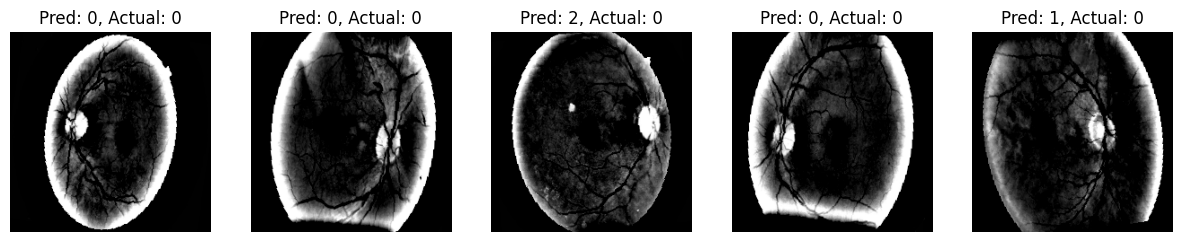

<ipython-input-9-76b6a7b2b59f>:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 26, Loss: 0.03787480068721754, Train Accuracy: 0.9869
Precision: 0.9869, Recall: 0.9869, F1-score: 0.9869
Test Accuracy: 0.8596
Precision: 0.8584, Recall: 0.8596, F1-score: 0.8574


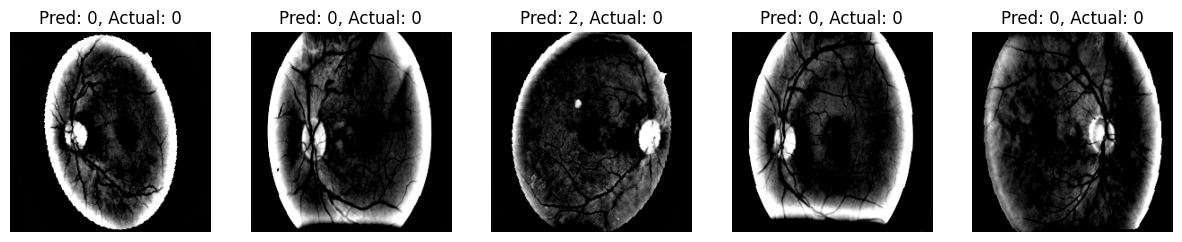

<ipython-input-9-76b6a7b2b59f>:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 27, Loss: 0.0335512338206172, Train Accuracy: 0.9887
Precision: 0.9887, Recall: 0.9887, F1-score: 0.9887
Test Accuracy: 0.8599
Precision: 0.8589, Recall: 0.8599, F1-score: 0.8578


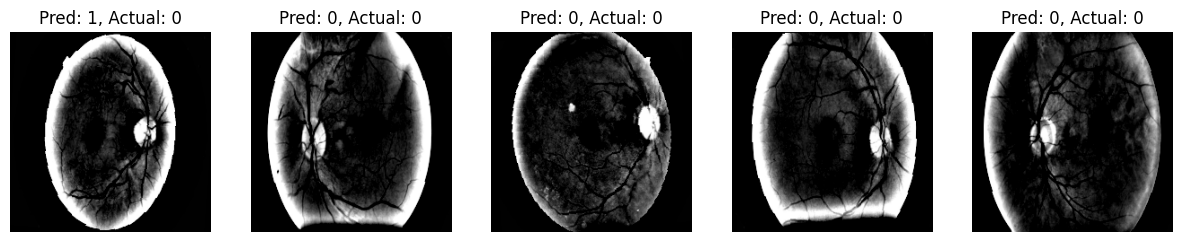

<ipython-input-9-76b6a7b2b59f>:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 28, Loss: 0.03194511950320756, Train Accuracy: 0.9888
Precision: 0.9889, Recall: 0.9888, F1-score: 0.9888
Test Accuracy: 0.8621
Precision: 0.8652, Recall: 0.8621, F1-score: 0.8604


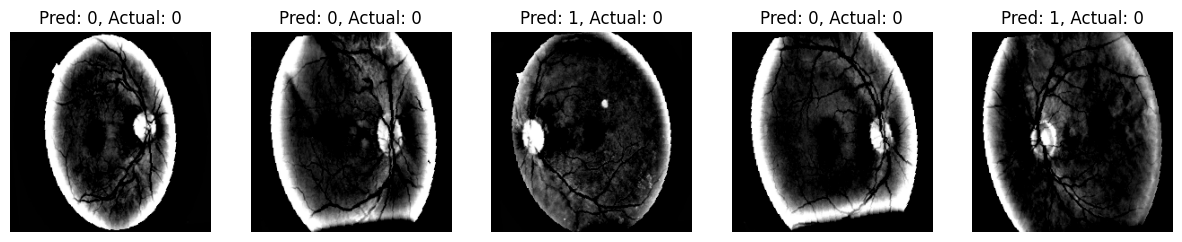

<ipython-input-9-76b6a7b2b59f>:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 29, Loss: 0.032150369524435306, Train Accuracy: 0.9887
Precision: 0.9887, Recall: 0.9887, F1-score: 0.9887
Test Accuracy: 0.8681
Precision: 0.8663, Recall: 0.8681, F1-score: 0.8660


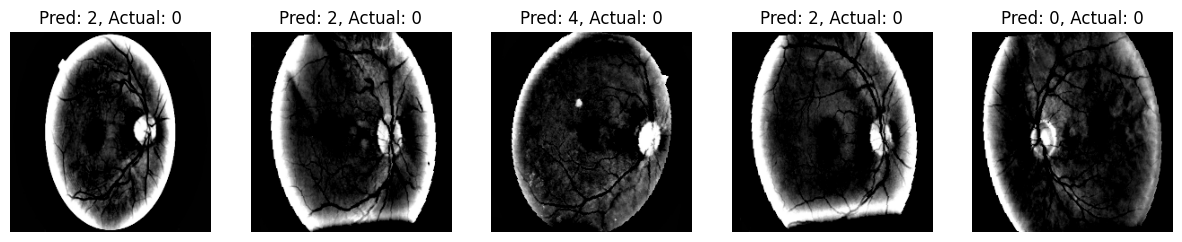

<ipython-input-9-76b6a7b2b59f>:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 30, Loss: 0.031619846372289914, Train Accuracy: 0.9886
Precision: 0.9886, Recall: 0.9886, F1-score: 0.9886
Test Accuracy: 0.8636
Precision: 0.8668, Recall: 0.8636, F1-score: 0.8648


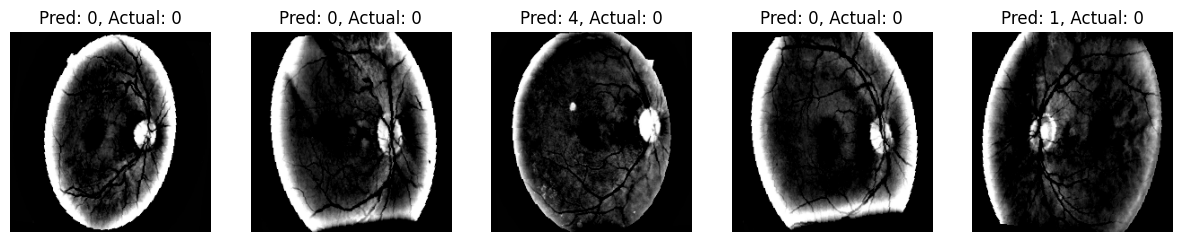

In [13]:
train(model, train_loader, val_loader, epochs=30)

In [14]:
torch.save(model.state_dict(), '/content/model.pth')